# Test
## Kandidaten der Gemeinderatswahlen 2022
05.01.2022


**Importiere die notwendigen Packages**

In [1]:
#pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly

In [73]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
#from datetime import datetime
import datetime
import geopandas as gpd
import folium 
import time

import plotly.express as px
import plotly.graph_objects as go



Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [74]:
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Datenimport


**Dataset auf INTEG Datenkatalog**: https://data.integ.stadt-zuerich.ch/dataset/int_dwh_politik_gemeinderatswahlen_2022_kandidierende

**Dataset auf PROD Datenkatalog**: https://data.stadt-zuerich.ch/dataset/politik_gemeinderatswahlen_2022_kandidierende

In [75]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "prod";
print(status)

prod


In [76]:
# Filepath
if status == "prod":
    fp = r"https://data.stadt-zuerich.ch/dataset/politik_gemeinderatswahlen_2022_kandidierende/download/gemeinderatswahlen_2022_kandidierende.csv"
else:
    fp = r"https://data.integ.stadt-zuerich.ch/dataset/int_dwh_politik_gemeinderatswahlen_2022_kandidierende/download/gemeinderatswahlen_2022_kandidierende.csv"
#download from INT-Datacatalog:
# https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bfs_bevreg_todesursache-aggregiert_alter_geschlecht_seit1995_od3120/download/BEV312OD3120.csv
print(fp)

https://data.stadt-zuerich.ch/dataset/politik_gemeinderatswahlen_2022_kandidierende/download/gemeinderatswahlen_2022_kandidierende.csv


In [77]:
# Read the data
data2betested = pd.read_csv(
    fp, 
    sep=',',
   #usecols=[0,1,2,3,4,6],
   #names=['stationid','year','month','avgtemp','latitude','longitude','elevation','station','countryid','country'],
   #skiprows=1,
    #parse_dates=True,
    #parse_dates=['GebJ'],    
    #date_parser=lambda x: x.datetime.datetime.strptime(x, '%Y'),
    #index_col="GebJ",
    low_memory=False    
    )

In der Folge ein paar erste Tests:

In [78]:
type(data2betested)

pandas.core.frame.DataFrame

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [79]:
data2betested.head(3)

Nachname Vorname  G  Bisher  GebJ Titel             Beruf  Kand  Liste ListeKurzbez  \
0  Ackermann    Ruth  W       0  1960   NaN          Kauffrau     5      7    Die Mitte   
1       Adir    Asya  W       0  1989   NaN  Sozialarbeiterin     6      6           AL   
2       Adir   Derya  W       0  1991   NaN  Sozialarbeiterin     8      6           AL   

         ListeBezeichnung Wahlkreis  
0               Die Mitte        11  
1  AL – Alternative Liste         3  
2  AL – Alternative Liste         9

### Hilfsspalten hinzufügen (Data enrichment)

1. Anzahl Personen 
2. Alter (aktuelles Jahr-Geburtsjahr)

In [80]:
data2betested = (
    data2betested.query("Wahlkreis != 0")
    .assign(
        AnzPers=lambda x: 1,
        Alter =lambda x: 2022-x.GebJ,
    )
    .sort_values('Nachname', ascending=True)
    #.head(200)
)
#data2betested.head(1)

3. Altersgruppe

Weitere Infos zu Kategorienbildung mit Pandas cut()-Methode: https://towardsdatascience.com/all-pandas-cut-you-should-know-for-transforming-numerical-data-into-categorical-data-1370cf7f4c4f

In [81]:
bins=[17, 20, 30, 40, 50, 60, 70, 80, 90]
labels=['18-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90']

data2betested['Alters_grp'] = pd.cut(data2betested['Alter'], bins, labels=labels)
#data2betested.sort_values("Alter", ascending=True).head(40)

4. Erstelle eine Datetime-Objekt der Geburtsjahre

In [82]:
data2betested['GebJ_date'] = pd.to_datetime(data2betested['GebJ'], format='%Y')

5. Füge eine Variablen hinzu, welche den ersten, den zweiten und die ersten beiden Buchstaben des Namens angeben.

In [83]:
data2betested["FirstLetter"]= data2betested["Vorname"].astype(str).str[0]
data2betested["SecondLetter"]= data2betested["Vorname"].astype(str).str[1]
data2betested["FirstTwoLetters"]= data2betested["Vorname"].str.slice(stop=2)
data2betested.sort_values(by='AnzPers', ascending=False, inplace=True, na_position='first')
#.str[0]
#data2betested["StartLetter"]= data2betested["Vorname"].str.extract(r"(\d{2})")
#print(data2betested)

In [84]:
data2betested.dtypes

Nachname                    object
Vorname                     object
G                           object
Bisher                       int64
GebJ                         int64
Titel                       object
Beruf                       object
Kand                         int64
Liste                        int64
ListeKurzbez                object
ListeBezeichnung            object
Wahlkreis                   object
AnzPers                      int64
Alter                        int64
Alters_grp                category
GebJ_date           datetime64[ns]
FirstLetter                 object
SecondLetter                object
FirstTwoLetters             object
dtype: object

In [85]:
data2betested.shape

(1075, 19)

Beschreibe einzelne Attribute

In [86]:
data2betested.describe()

Bisher  GebJ  Kand  Liste  AnzPers  Alter
count    1075  1075  1075   1075     1075   1075
mean        0  1974     8      5        1     48
std         0    14     5      3        0     14
min         0  1936     1      1        1     18
25%         0  1963     4      3        1     36
50%         0  1974     7      5        1     48
75%         0  1986    11      7        1     59
max         1  2004    22     12        1     86

Wie viele Nullwerte gibt es im Datensatz?

In [87]:
data2betested.isnull().sum()

Nachname              0
Vorname               0
G                     0
Bisher                0
GebJ                  0
Titel               903
Beruf                 0
Kand                  0
Liste                 0
ListeKurzbez          0
ListeBezeichnung      0
Wahlkreis             0
AnzPers               0
Alter                 0
Alters_grp            0
GebJ_date             0
FirstLetter           0
SecondLetter          0
FirstTwoLetters       0
dtype: int64

### Kennzahlen für ZdW

In [126]:
frauen = data2betested[(data2betested.G == "W")]
frauen.describe()

Bisher  GebJ  Kand  Liste  AnzPers  Alter
count     468   468   468    468      468    468
mean        0  1975     8      5        1     47
std         0    14     5      3        0     14
min         0  1939     1      1        1     18
25%         0  1964     4      3        1     36
50%         0  1975     7      5        1     47
75%         0  1986    10      7        1     58
max         1  2004    22     12        1     83

In [127]:
maenner = data2betested[(data2betested.G == "M")]
maenner.describe()

Bisher  GebJ  Kand  Liste  AnzPers  Alter
count     607   607   607    607      607    607
mean        0  1973     8      5        1     49
std         0    15     5      3        0     15
min         0  1936     1      1        1     19
25%         0  1962     3      3        1     36
50%         0  1973     7      5        1     49
75%         0  1986    11      7        1     60
max         1  2003    22     12        1     86

In [122]:
avg_geschlecht_alter = data2betested\
    .groupby(['G']) \
    .agg(avg_alter=('Alter', 'mean'), cnt=('Alter', 'count'), med_alter=('Alter', 'median'), min_alter=('Alter', 'min'), max_alter=('Alter', 'max') ) \
    .query('G != "a"') \
    .sort_values('avg_alter', ascending=False)

avg_geschlecht_alter.reset_index() 

#column.agg([np.sum, np.mean, np.std, np.median, np.var, np.min, np.max])

G  avg_alter  cnt  med_alter  min_alter  max_alter
0  M         49  607         49         19         86
1  W         47  468         47         18         83

In [123]:
avg_partei_alter = data2betested\
    .groupby(['ListeKurzbez']) \
    .agg(avg_alter=('Alter', 'mean'), cnt=('Alter', 'count'), med_alter=('Alter', 'median'), min_alter=('Alter', 'min'), max_alter=('Alter', 'max') ) \
    .query('ListeKurzbez != "a"') \
    .sort_values('avg_alter', ascending=False)

avg_partei_alter.reset_index() 

ListeKurzbez  avg_alter  cnt  med_alter  min_alter  max_alter
0           EVP         55  125         57         20         83
1           SVP         54  125         55         20         86
2     Die Mitte         53  114         54         20         86
3       FL ZÜRI         52   44         50         30         76
4           PdA         51   38         58         20         82
5            AL         48  125         48         18         76
6     I love ZH         48    1         48         48         48
7         Grüne         46  125         48         19         71
8           FDP         44  125         43         20         76
9           GLP         43  125         43         19         73
10           SP         39  125         36         20         69
11         Volt         31    3         27         19         46

In [124]:
avg_partei_alter_g = data2betested\
    .groupby(['ListeKurzbez','G']) \
    .agg(avg_alter=('Alter', 'mean'), cnt=('Alter', 'count'), med_alter=('Alter', 'median'), min_alter=('Alter', 'min'), max_alter=('Alter', 'max') ) \
    .query('ListeKurzbez != "a"') \
    .sort_values('avg_alter', ascending=False)

avg_partei_alter_g.reset_index()

ListeKurzbez  G  avg_alter  cnt  med_alter  min_alter  max_alter
0           EVP  W         57   53         61         21         83
1           SVP  W         56   33         59         28         78
2       FL ZÜRI  W         55   25         55         30         74
3     Die Mitte  M         54   75         55         20         86
4           EVP  M         54   72         56         20         82
5           SVP  M         53   92         54         20         86
6           PdA  W         52   13         58         20         76
7     Die Mitte  W         51   39         54         21         72
8            AL  M         51   59         53         20         76
9           PdA  M         51   25         61         24         82
10      FL ZÜRI  M         48   19         47         30         76
11    I love ZH  M         48    1         48         48         48
12        Grüne  W         47   66         49         22         71
13           AL  W         45   66         46         18         67
14        Grüne  M         45   59         48         19         69
15          GLP  M         45   64         44         19         73
16          FDP  W         44   46         42         22         76
17          FDP  M         43   79         43         20         73
18          GLP  W         41   61         41         21         60
19           SP  M         39   59         37         20         69
20           SP  W         38   66         34         22         64
21         Volt  M         31    3         27         19         46

### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

#### Parsing & Formatting Strings to Dataframes
- [**Cheat Sheet**](https://strftime.org/)
- Python documentation for **strptime**: [string **parse** time, Python 3](https://docs.python.org/3/library/datetime.html#datetime.datetime.strptime)
- Python documentation for strptime/**strftime**: [string **format** time,Python 3](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior)



In [17]:
data2betested = data2betested.set_index("GebJ_date")
#data2betested = data2betested.drop(columns=["StichtagDatMM"])

In [18]:
#data2betested.info()
data2betested.index.year.unique()

Int64Index([1960, 1956, 1987, 1962, 1996, 1979, 1959, 1950, 1982, 1985, 1973, 1965, 1972, 1951,
            1992, 1989, 1978, 1990, 1955, 1970, 1980, 1991, 1988, 1993, 1964, 1971, 1957, 1994,
            1953, 1954, 1966, 1958, 1984, 1975, 1977, 1961, 1968, 1946, 1997, 1963, 1974, 1983,
            1936, 1986, 2001, 1967, 1969, 1981, 1949, 2002, 2004, 1944, 1945, 1995, 1976, 1998,
            1942, 1952, 1941, 2000, 1947, 1948, 1943, 1999, 1939, 1940, 2003],
           dtype='int64', name='GebJ_date')

#### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [19]:
#data2betested.loc["1970-01-01"]
data2betested.loc["1940":"1945"].sort_values('Alter',ascending=False)


Nachname       Vorname  G  Bisher  GebJ          Titel                     Beruf  \
GebJ_date                                                                                          
1940-01-01         Büchi     Max Jakob  M       0  1940            NaN    dipl. Bauingenieur ETH   
1940-01-01        Aicher   Jean (Hans)  M       0  1940            NaN                   Rentner   
1941-01-01    Waldispühl         Bruno  M       0  1941            NaN                   Rentner   
1942-01-01          Müri  Rosa (Rahel)  W       0  1942            NaN  Schulische Heilpädagogin   
1943-01-01        Sieber        Werner  M       0  1943            NaN           pens. Waisenrat   
1943-01-01        Härtli         Peter  M       0  1943            NaN                   Rentner   
1944-01-01  Rothenberger          Hans  M       0  1944            NaN  pens. Erwachsenenbildner   
1944-01-01        Werner        Gérald  M       0  1944            NaN                   Rentner   
1944-01-01       Dublanc        Marcel  M       0  1944  lic. oec. HSG                  Kaufmann   
1944-01-01      Engesser         Nelly  W       0  1944            NaN      pens. GL-Assistentin   
1944-01-01         Baldi          Theo  M       0  1944            NaN    Kaufmann selbstständig   
1945-01-01        Medici         Marco  M       0  1945            NaN                   Rentner   
1945-01-01      Garzotto         Bruno  M       0  1945            NaN          Schreinermeister   
1945-01-01         Hauri          Theo  M       0  1945            NaN               Unternehmer   

            ...  Wahlkreis  AnzPers Alter Alters_grp FirstLetter  SecondLetter  FirstTwoLetters  
GebJ_date   ...                                                                                  
1940-01-01  ...      7 + 8        1    82      81-90           M             a               Ma  
1940-01-01  ...      4 + 5        1    82      81-90           J             e               Je  
1941-01-01  ...          3        1    81      81-90           B             r               Br  
1942-01-01  ...         10        1    80      71-80           R             o               Ro  
1943-01-01  ...      4 + 5        1    79      71-80           W             e               We  
1943-01-01  ...      1 + 2        1    79      71-80           P             e               Pe  
1944-01-01  ...          3        1    78      71-80           H             a               Ha  
1944-01-01  ...         10        1    78      71-80           G             é               Gé  
1944-01-01  ...          9        1    78      71-80           M             a               Ma  
1944-01-01  ...      4 + 5        1    78      71-80           N             e               Ne  
1944-01-01  ...          3        1    78      71-80           T             h               Th  
1945-01-01  ...      7 + 8        1    77      71-80           M             a               Ma  
1945-01-01  ...          3        1    77      71-80           B             r               Br  
1945-01-01  ...         11        1    77      71-80           T             h               Th  

[14 rows x 18 columns]

Sortiere einen DataFrame

In [20]:
#anz_vn_gebjahr_sex.sort_values(by='AnzGebuWir', ascending=False, na_position='first')

**Einfache Visualisierungen zur Plausi**

Exploriere die Daten mit Pivottable.JS

In [21]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

### Aggregationen und Dataviz mit Altair

[Link zur Altair-Doku](https://altair-viz.github.io/gallery/multiline_highlight.html)

#### Selektionen und Aggregationen

Check this [Doku](https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/)

##### Nach Geschlechterverteilung

In [128]:
sum_geschlecht_partei = data2betested.groupby(['ListeBezeichnung', 'G'])[['AnzPers']].agg('sum')
#sum_geschlecht_partei

In [129]:
sum_geschlecht_wahlkreis = data2betested.groupby(['Wahlkreis', 'G'])[['AnzPers']].agg('sum')
#sum_geschlecht_wahlkreis

In [130]:
sum_geschlecht_wahlkreis_liste = data2betested.groupby(['Wahlkreis','ListeBezeichnung', 'G'])[['AnzPers']].agg('sum')
#sum_geschlecht_wahlkreis_liste

In [131]:
sum_geschlecht_altersgruppe_ListeBez = data2betested.groupby(['ListeBezeichnung', 'Alters_grp', 'G'])[['AnzPers']].agg('sum')
#sum_geschlecht_altersgruppe_ListeBez.head(100)

##### Nach Beruf

In [132]:
sum_beruf = data2betested.groupby(['Beruf'])[['AnzPers']].agg('sum')
#sum_beruf.sort_values('AnzPers', ascending=False)

In [133]:
sum_beruf_ListeBezeichnung = data2betested.groupby(['Beruf', 'ListeBezeichnung'])[['AnzPers']].agg('sum')
sum_beruf_ListeBezeichnung.sort_values('AnzPers', ascending=False)

AnzPers
Beruf                             ListeBezeichnung                         
Unternehmer                       FDP.Die Liberalen                       8
Sozialarbeiterin                  AL – Alternative Liste                  8
Unternehmer                       Schweizerische Volkspartei – SVP        7
Rentner                           Partei der Arbeit                       5
Juristin                          GLP – Grünliberale Partei               5
...                                                                     ...
Immobilienbewirtschafter          FDP.Die Liberalen                       1
Immobilienbewirtschafter, Oekonom Schweizerische Volkspartei – SVP        1
Informatik-Ingenieur              Die Mitte                               1
Informatiker                      Evangelische Volkspartei EVP            1
Übersetzerin                      AL – Alternative Liste                  1

[977 rows x 1 columns]

In [135]:
#data2betested.dtypes

In [136]:
sum_beruf_geschlecht = data2betested.groupby(['Beruf', 'G'])[['AnzPers']].agg('sum')
sum_beruf_geschlecht.sort_values('AnzPers', ascending=False)

AnzPers
Beruf                          G         
Unternehmer                    M       20
Rentner                        M       13
Juristin                       W       13
Architekt                      M       12
Rentnerin                      W        9
...                                   ...
Ingenieurin, Account Managerin W        1
Inhaber Velogeschäft           M        1
Innovationsmanagerin           W        1
Insektenforscher               M        1
Übersetzerin                   W        1

[836 rows x 1 columns]

#### Durch Aggregierung entstandene GroupedDataFrames auflösen mit `reset_index()`

In [137]:
test = sum_geschlecht_partei.reset_index()
test.head(2)

ListeBezeichnung  G  AnzPers
0  AL – Alternative Liste  M       59
1  AL – Alternative Liste  W       66

#### Altair-Liniengrafik

[Link](https://altair-viz.github.io/gallery/multiline_highlight.html)

In [138]:
alt.Chart(test.reset_index()).mark_line(strokeWidth=1).encode(
    x='ListeBezeichnung',
    y='AnzPers',
    color='G',
    tooltip=['AnzPers','G', 'ListeBezeichnung']  
).properties(width=800, height=100).interactive()

alt.Chart(...)

In [139]:
alt.Chart(test.reset_index()).mark_circle(size=60).encode(
    x='ListeBezeichnung',
    y='AnzPers',
    color = 'G',
    #color=alt.Color('value', scale=alt.Scale(scheme='blues')),
    tooltip=['AnzPers','G', 'ListeBezeichnung']
).interactive().properties(width=800, height=200).interactive()

alt.Chart(...)

### Daten in interaktiver Treemap zeigen

- Dazu gibt es eine sehr nützliche Webseite https://plotly.com/python/treemaps/
- Zu Farbskalen, siehe: https://plotly.com/python/builtin-colorscales/
- Weiters: https://plotly.com/python-api-reference/generated/plotly.express.treemap.html

In [140]:
sum_geschlecht_altersgruppe_listekurzbez = data2betested.groupby(['ListeKurzbez', 'Alters_grp', 'G'])[['AnzPers']].agg('sum')
sum_geschlecht_altersgruppe_listekurzbez.reset_index().query("AnzPers > 0").sort_values("AnzPers", ascending=True).head(2)

ListeKurzbez Alters_grp  G  AnzPers
76      FL ZÜRI      71-80  M        1
47          EVP      81-90  W        1

In [141]:
import plotly.io as pio
pio.templates
pio.template = "plotly_white"

In [142]:
data2betested.dtypes

Nachname                    object
Vorname                     object
G                           object
Bisher                       int64
GebJ                         int64
Titel                       object
Beruf                       object
Kand                         int64
Liste                        int64
ListeKurzbez                object
ListeBezeichnung            object
Wahlkreis                   object
AnzPers                      int64
Alter                        int64
Alters_grp                category
GebJ_date           datetime64[ns]
FirstLetter                 object
SecondLetter                object
FirstTwoLetters             object
dtype: object

#### Altersgruppe, Geschlecht, Liste

##### Heatmaps

In [143]:
sum_geschlecht_altersgruppe_liste_wahlkr = data2betested.groupby(['Alter', 'G','ListeKurzbez', 'Wahlkreis'])[['AnzPers']].agg('sum')
sum_geschlecht_altersgruppe_liste_wahlkr.sort_values("Wahlkreis", ascending=True).head(2)

AnzPers
Alter G ListeKurzbez Wahlkreis         
18    W AL           1 + 2            1
29    W FDP          1 + 2            1

In [144]:
#df = px.data.tips()
df = sum_geschlecht_altersgruppe_liste_wahlkr.reset_index().query("ListeKurzbez !='Volt' and ListeKurzbez !='I love ZH'and ListeKurzbez !='FL ZÜRI'")

fig1 = px.density_heatmap(df, x="Alter", y="Wahlkreis", z="AnzPers", histfunc="sum", facet_row="G", facet_col="ListeKurzbez") #
fig1.show()

##### Treemaps

In [145]:
sum_geschlecht_altersgruppe_ListeBez.head()

AnzPers
ListeBezeichnung       Alters_grp G         
AL – Alternative Liste 18-20      M        2
                                  W        2
                       21-30      M        5
                                  W        6
                       31-40      M        9

In [146]:
df = sum_geschlecht_altersgruppe_listekurzbez.reset_index().query("AnzPers > 0")

fig = px.treemap(df, path=[px.Constant("Kandidierende nach Altersgruppe, Geschlecht und Partei"), 'Alters_grp','ListeKurzbez', 'G']
                 , values='AnzPers'
                 , color='ListeKurzbez'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 , color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                #, color_continuous_scale='GnBu'
                #, color_continuous_midpoint=np.average(df['AnzPers'], weights=df['AnzPers']))           
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

In [ ]:
df = sum_geschlecht_altersgruppe_listekurzbez.reset_index().query("AnzPers > 0")

fig = px.treemap(df, path=[px.Constant("Kandidierende nach Partei, Altersgruppe und Geschlecht"), 'ListeKurzbez', 'Alters_grp', 'G']
                 , values='AnzPers'
                 , color='ListeKurzbez'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 , color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E', 'Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                #, color_continuous_scale='GnBu'
                #, color_continuous_midpoint=np.average(df['AnzPers'], weights=df['AnzPers']))           
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

In [ ]:
df = sum_geschlecht_altersgruppe_listekurzbez.reset_index().query("AnzPers > 0")

fig = px.treemap(df, path=[px.Constant("Kandidierende nach Liste, Altersgruppe und Geschlecht"), 'ListeKurzbez','Alters_grp', 'G']
                 ,values='AnzPers'
                 ,color='AnzPers'
                 , hover_data=['ListeKurzbez']
                ,color_continuous_scale='BuPu'
                ,color_continuous_midpoint=np.average(df['AnzPers'], weights=df['AnzPers']))
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()


#### Partei und Beruf
Für eine sinnvolle Darstellung müssten die Berufe kategorisiert werden.

In [ ]:
df = sum_beruf_ListeBezeichnung.reset_index().query("Beruf !=''")

fig = px.treemap(df, path=[px.Constant("Kandidierende nach Partei und Beruf"), 'ListeBezeichnung', 'Beruf']
                 , values='AnzPers'
                 , color='AnzPers'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 #, color_discrete_map={'(?)':'lightblue', 'Beruf':'gold', 'ListeBezeichnung':'darkblue'}                 
                 ## bei continuous scales (bei Zahlenwerten):
                #, color_continuous_scale='GnBu'
                #, color_continuous_midpoint=np.average(df['AnzPers'], weights=df['AnzPers']))           
                )
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()


In [ ]:
df = sum_beruf_ListeBezeichnung.reset_index().query("Beruf !=''")

fig = px.treemap(df, path=[px.Constant("Kandidierende nach Beruf und Partei"), 'Beruf', 'ListeBezeichnung']
                 ## bei discrete scales (bei Klassen und Strings):
                 , values='AnzPers'
                 , color='Beruf'
                 , color_discrete_map={'(?)':'lightblue', 'Beruf':'gold', 'ListeBezeichnung':'darkblue'}                 
                 ## bei continuous scales (bei Zahlenwerten):
                #, color_continuous_scale='GnBu'
                #, color_continuous_midpoint=np.average(df['AnzPers'], weights=df['AnzPers']))           
                )

fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()


##### Scatter Gapminder

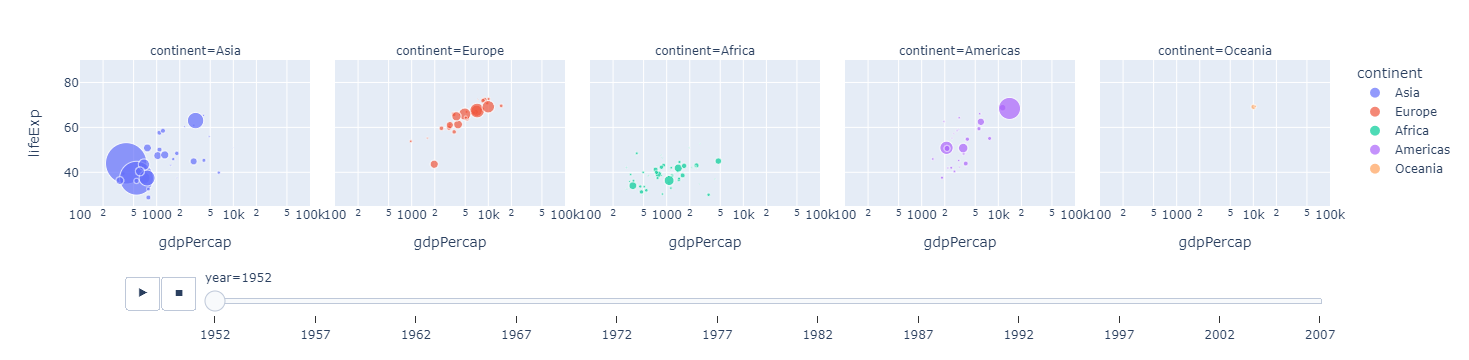

In [244]:
df = px.data.gapminder()
fig = px.scatter(df, x="gdpPercap", y="lifeExp", animation_frame="year", animation_group="country",
           size="pop", color="continent", hover_name="country", facet_col="continent",
           log_x=True, size_max=45, range_x=[100,100000], range_y=[25,90])
fig.show()

In [246]:
px.data.gapminder().head(2)

country continent  year  lifeExp      pop  gdpPercap iso_alpha  iso_num
0  Afghanistan      Asia  1952       29  8425333        779       AFG        4
1  Afghanistan      Asia  1957       30  9240934        821       AFG        4

In [269]:
sum_ListeKurzbez_geschlecht_altersgruppe = data2betested.groupby(['ListeKurzbez', 'Wahlkreis', 'Alters_grp', 'G'])[['AnzPers']].agg('sum')
sum_ListeKurzbez_geschlecht_altersgruppe.reset_index().head(1)

ListeKurzbez Wahlkreis Alters_grp  G  AnzPers
0           AL     1 + 2      18-20  M        2

#### HIER STEHEN GEBLIEBEN
------------------------------------

Der df müsste angepasst werden, sodass die Struktur so wäre:

- Partei
- Wahlkreis
- Jahr
- Calc: anz_frauen, anz_maenner, etc.


In [271]:
df = sum_ListeKurzbez_geschlecht_altersgruppe.reset_index().query("AnzPers > 0")
df['jahr']=2022
df.dtypes

ListeKurzbez      object
Wahlkreis         object
Alters_grp      category
G                 object
AnzPers            int64
jahr               int64
dtype: object

In [ ]:
fig = px.scatter(df, x="Alters_grp", y="ListeKurzbez", animation_frame="jahr", animation_group="Alters_grp",
           size="AnzPers", color="G", hover_name="ListeKurzbez", facet_col="ListeKurzbez",
           log_x=False, size_max=45, range_x=[0,100], range_y=[0,90])
fig.show()

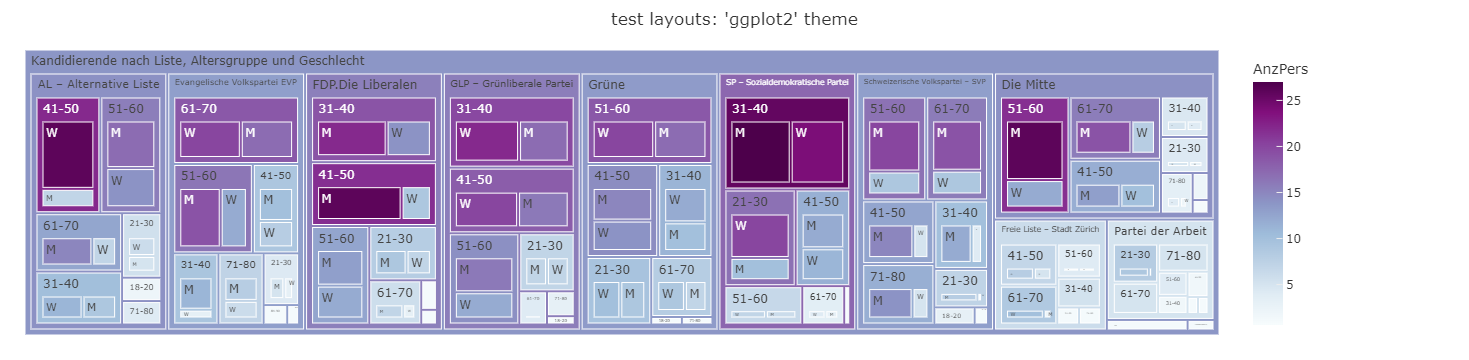

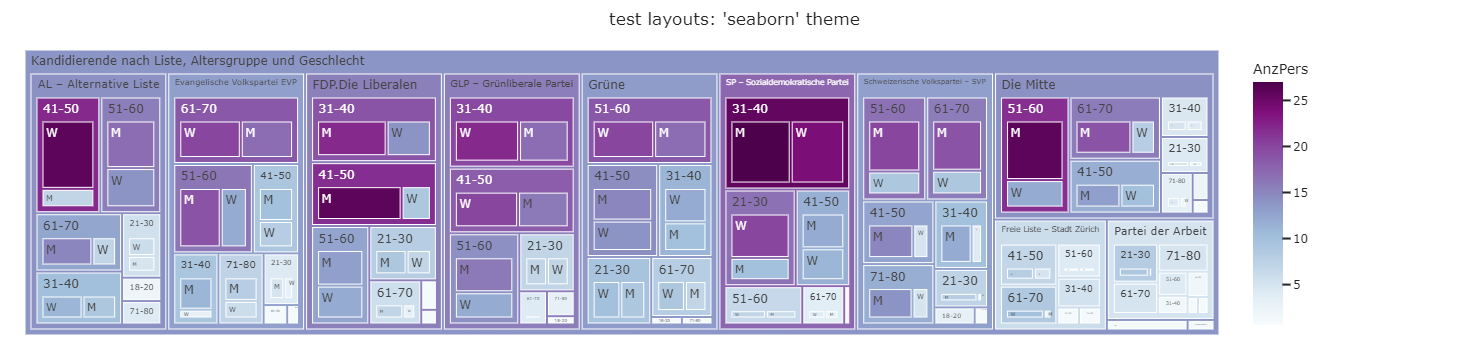

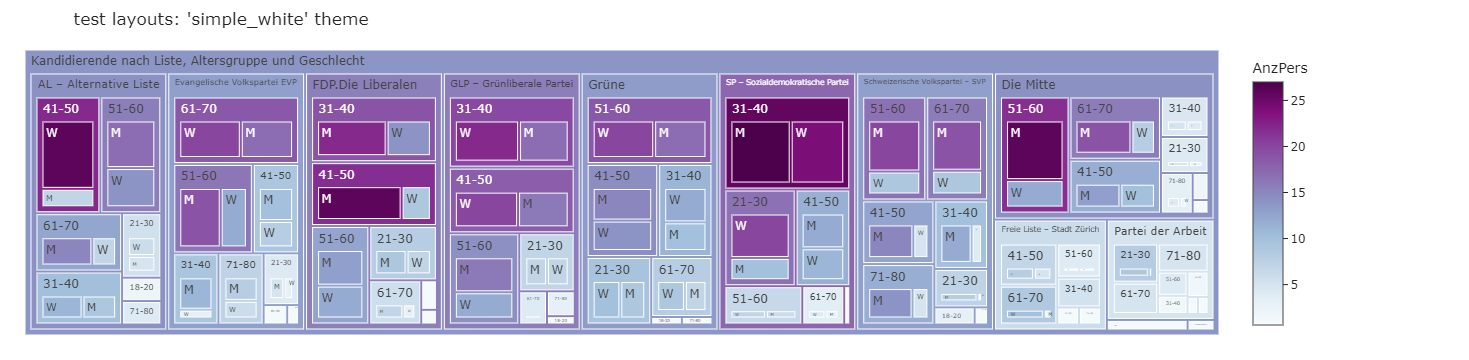

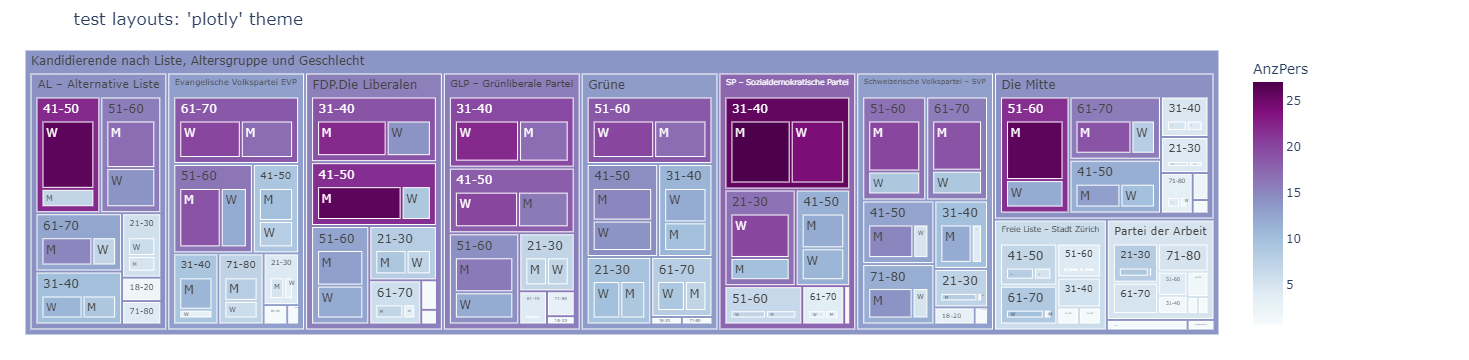

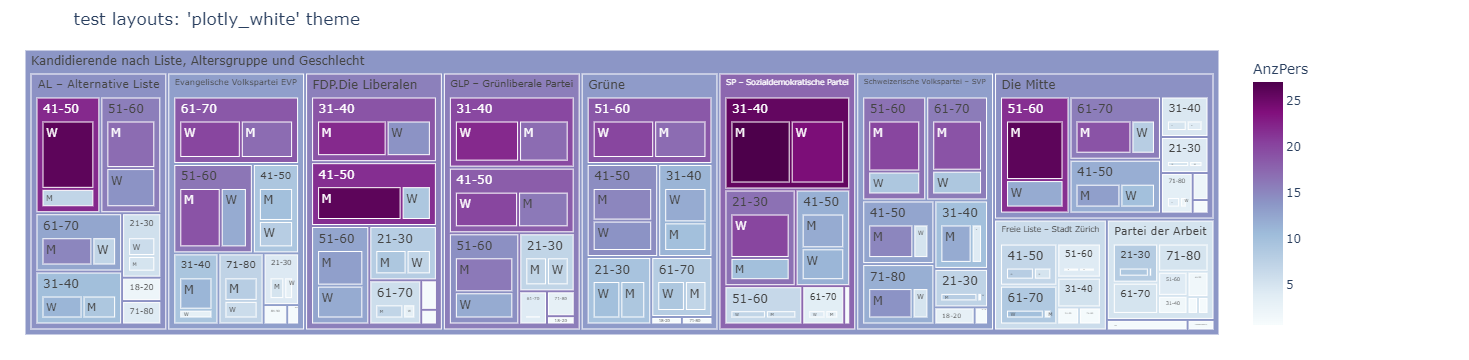

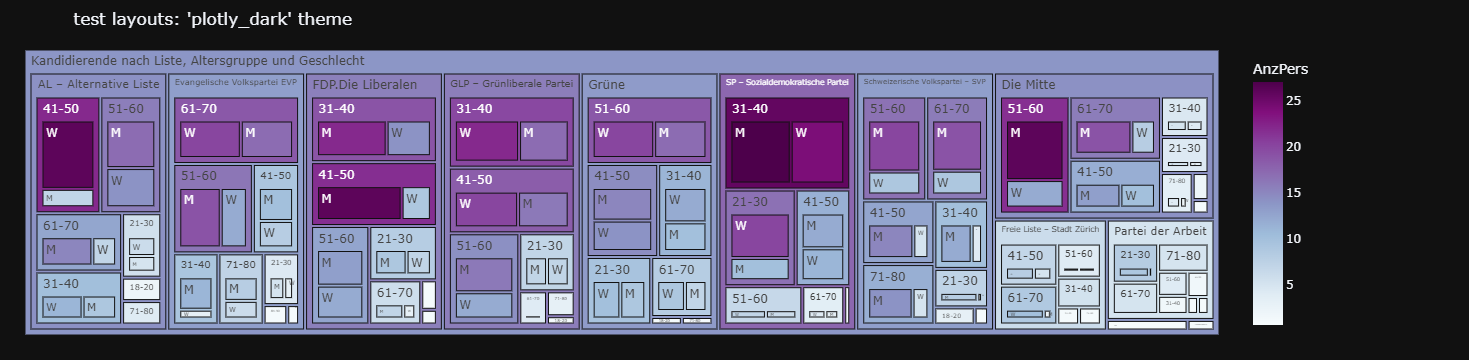

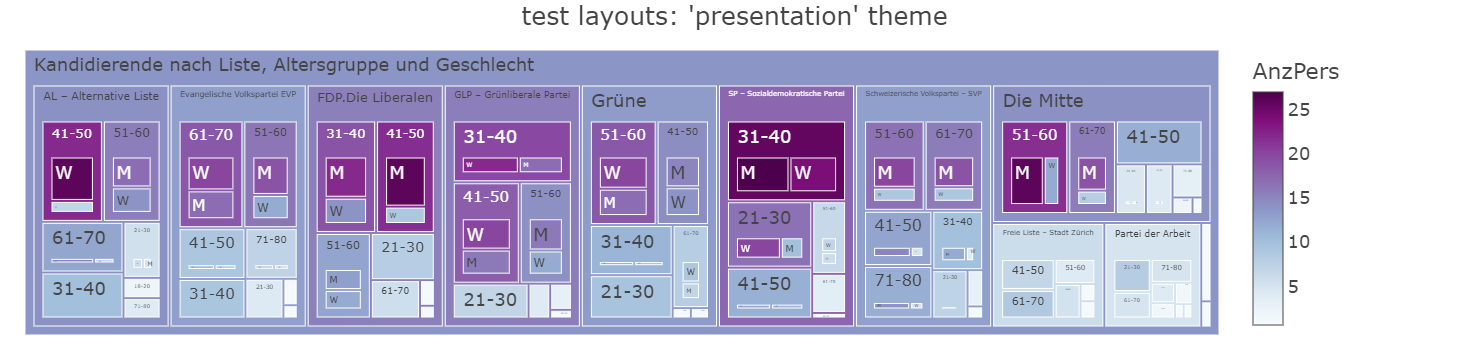

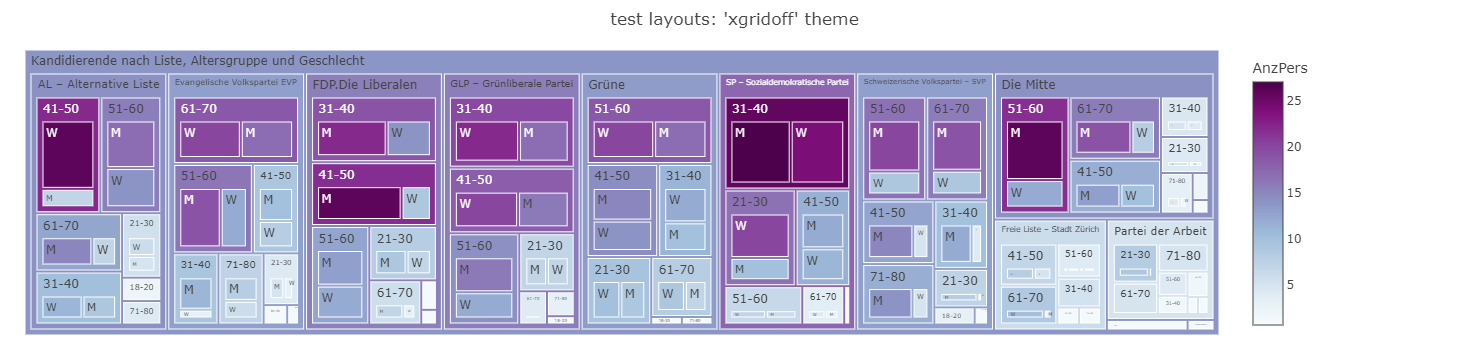

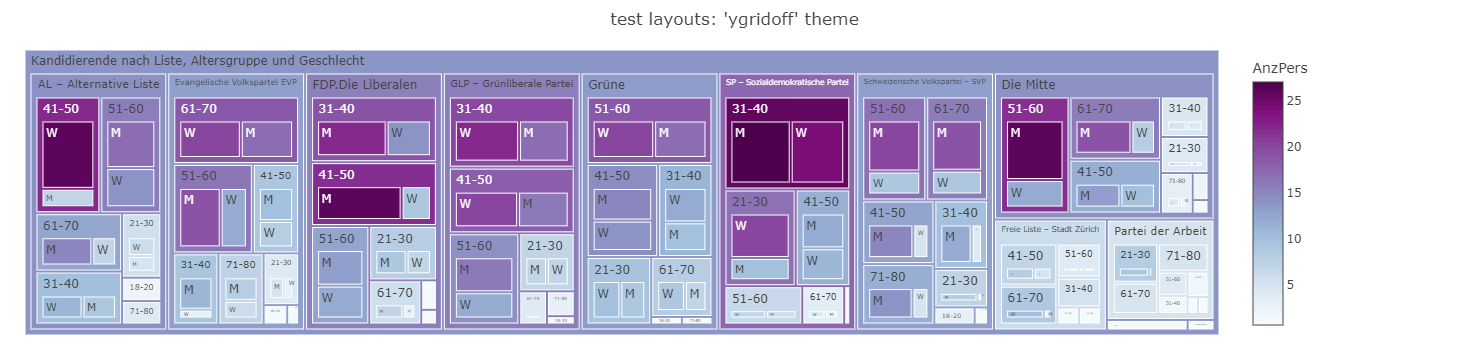

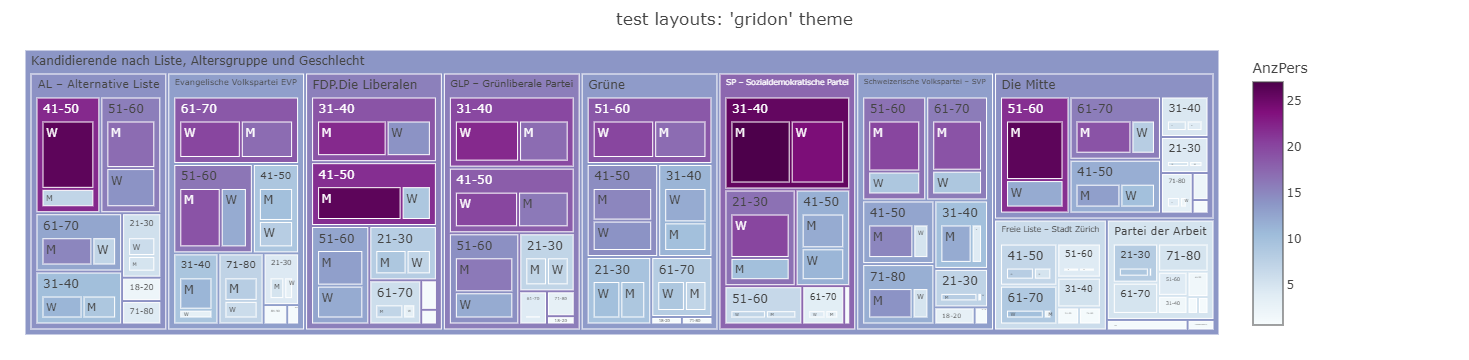

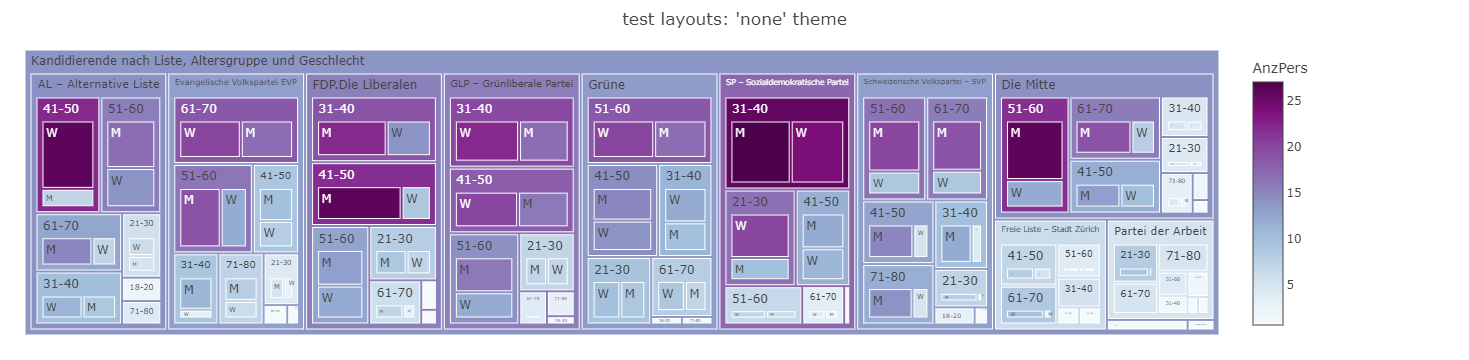

In [29]:
for template in ['ggplot2', 'seaborn', 'simple_white', 'plotly','plotly_white', 'plotly_dark', 'presentation', 'xgridoff','ygridoff', 'gridon', 'none']:
    fig.update_layout(template=template, title="test layouts: '%s' theme" % template)
    fig.show()